In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_dict = {"Nominal GDP":"GDP",
             "Real GDP":"GDPC1",
             "Real Net Exports":"NETEXC",
             "Real Government EI": "GCEC1",
             "Real Investment": "GPDIC1",
             "Real Consumption": "PCECC96",
#              "PPI: All Comodities": "PPIACO",
#              "PPI: Lumber and Wood Products":"WPU081",
#             "PPI: Copper and Copper Products":"WPUSI019011",
#             "PPI: Gas and Oil Extraction":"PCU21112111",
#             "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
            "$CPI_{Urban}$":"CPIAUCNS",
#              "1 Month UST": "DGS1MO",
#              "3 Month UST": "DGS3MO",
#              "1 Year UST": "DGS1",
#              "2 Year UST": "DGS2",
#              "5 Year UST": "DGS5",
             "10 Year UST": "DGS10",
             "30 Year UST": "DGS30",   
#              "5 Year TIPS":"DFII5",
#              "10 Year TIPS": "DFII10",
             
               "Effective Federal Funds Rate (%)": "DFF",
             
#              "$CPI_{Core}$":"CPILFESL",
#             "Industrial Production Index":"INDPRO",
#             "$\pi_{e_{5Y}}$":"T5YIE",
#              "$\pi_{e_{10Y}}$":"T10YIE",
             "Currency in Circulation":"WCURCIR",
#              "M2":"WM2NS",
#             "Personal Savings Rate":"PSAVERT",
#             "Private Weekly Employee Earnings":"CES0500000011",
#             "Private Hourly Nonsupervisory Earnings":"AHETPI",
            "Unemployment Rate":"UNRATE"}
freq = "Q"
start = datetime.datetime(2000, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)
# df["Nominal GDP"] = df["Nominal GDP"].mul(1000)
# df["Real GDP"] = df["Real GDP"].mul(1000)

C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
for key in df:
    if "Earnings" in key:
        df["Real " + key ] = df[key].div(df["$CPI_{Urban}$"])


C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3953828140.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3953828140.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([round(y,2) for y in ax2.get_yticks()], color = "C1")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3953828140.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 90)
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3953828140.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3953828140.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.se

Text(0.5, 0.92, 'Logged Values')

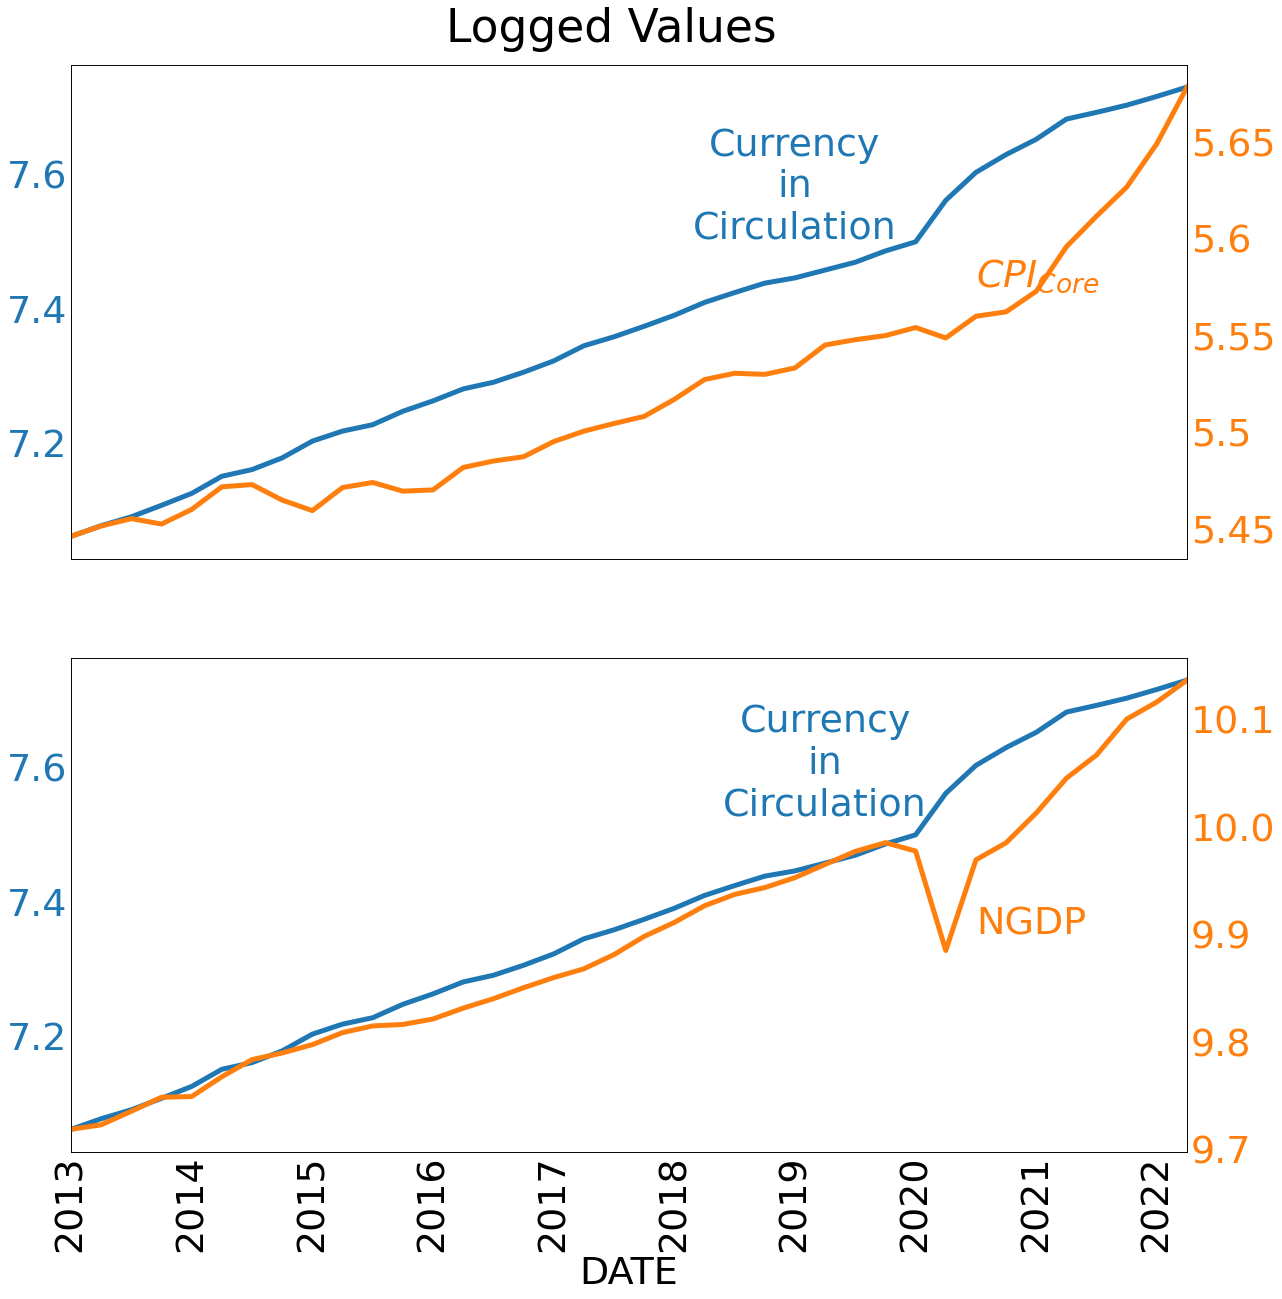

In [4]:
fontsize = 38
plt.rcParams.update({'font.size': fontsize})
plot_vars = ["$CPI_{Urban}$",
            "Currency in Circulation"]
plot_df = np.log(df[plot_vars]).loc["2013":]
fig, a = plt.subplots(2,1, figsize = (20,20))

ax = a[0]
plot_df[[plot_vars[1]]].plot.line(ax = ax,
                                    legend = False,
                                    linewidth= 5)
ax.set_xlabel("")
ax2 = ax.twinx()

plot_df[[plot_vars[0]]].plot.line(ax = ax2,
                                         legend = False,
                                              color = "C1",
                                              linewidth = 5)
ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([round(y,2) for y in ax2.get_yticks()], color = "C1")
ax2.text("2020-08-01", 5.575, "$CPI_{Core}$", color = "C1", fontsize = fontsize)
ax2.text("2019-03-01", 5.6, "Currency\nin\nCirculation",ha = "center", color = "C0",
         fontsize = fontsize)
ax.set_xticklabels([], rotation = 90)
ax2.set_xticklabels([], rotation = 90)
ax.tick_params('both', length=0, which='both')
ax2.tick_params('both', length=0, which='both')


plot_vars = ["Nominal GDP",
            "Currency in Circulation"]
plot_df = np.log(df[plot_vars]).loc["2013":]

ax = a[1]
plot_df[[plot_vars[1]]].plot.line(ax = ax,
                                    legend = False,
                                 linewidth = 5)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax2 = ax.twinx()
plot_df[[plot_vars[0]]].plot.line(ax = ax2,
                                  legend = False,
                                  color = "C1",
                                 linewidth = 5)
ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([round(y,1) for y in ax2.get_yticks()], color = "C1")

ax2.text("2020-08-01", 9.9, "NGDP", color = "C1",  fontsize = fontsize)
ax2.text("2019-04-01", 10.011, "Currency\nin\nCirculation",ha = "center", color = "C0",  fontsize = fontsize)
ax.tick_params('both', length=0, which='both')
ax2.tick_params('both', length=0, which='both')
plt.suptitle("Logged Values",y = .92)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2399993470.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 90)
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2399993470.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2399993470.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([round(y,1) for y in ax2.get_yticks()], color = "C1")


Text(2019-04-01, 10.011, 'Currency\nin\nCirculation')

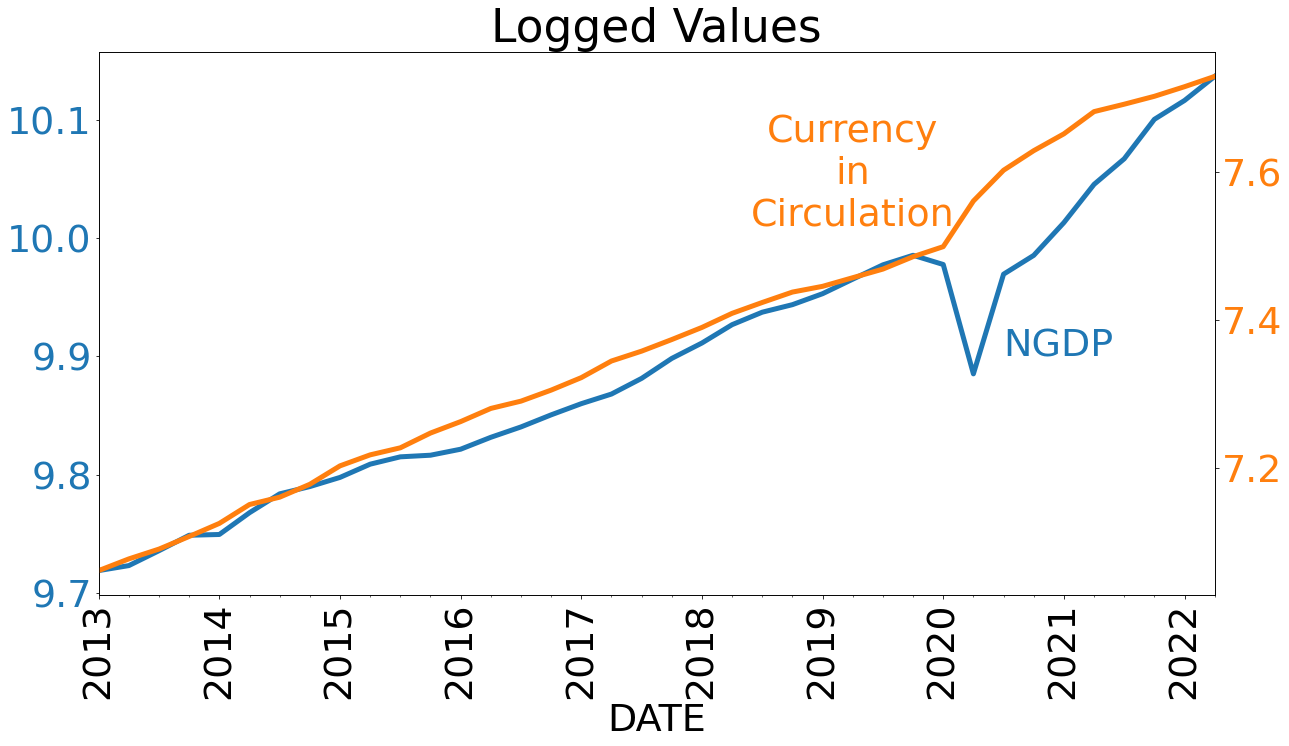

In [5]:
plot_vars = ["Nominal GDP",
            "Currency in Circulation"]
plot_df = np.log(df[plot_vars]).loc["2013":]
fig, ax = plt.subplots(figsize = (20,10))

plot_df[[plot_vars[0]]].plot.line(ax = ax,
                                    legend = False,
                                 linewidth = 5)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_title("Logged Values")
ax2 = ax.twinx()
plot_df[[plot_vars[1]]].plot.line(ax = ax2,
                                  legend = False,
                                  color = "C1",
                                 linewidth = 5)
ax.set_yticklabels([round(y,1) for y in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([round(y,1) for y in ax2.get_yticks()], color = "C1")

ax.text("2020-08-01", 9.9, "NGDP", color = "C0")
ax.text("2019-04-01", 10.011, "Currency\nin\nCirculation",ha = "center", color = "C1")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\594419311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["$V_C$"] = plot_df["Nominal GDP"].div(plot_df["Currency in Circulation"])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\594419311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[plot_vars[2]] = df[plot_vars[2]]
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\594419311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

Text(2009-01-01, 6.1, '$V_C$')

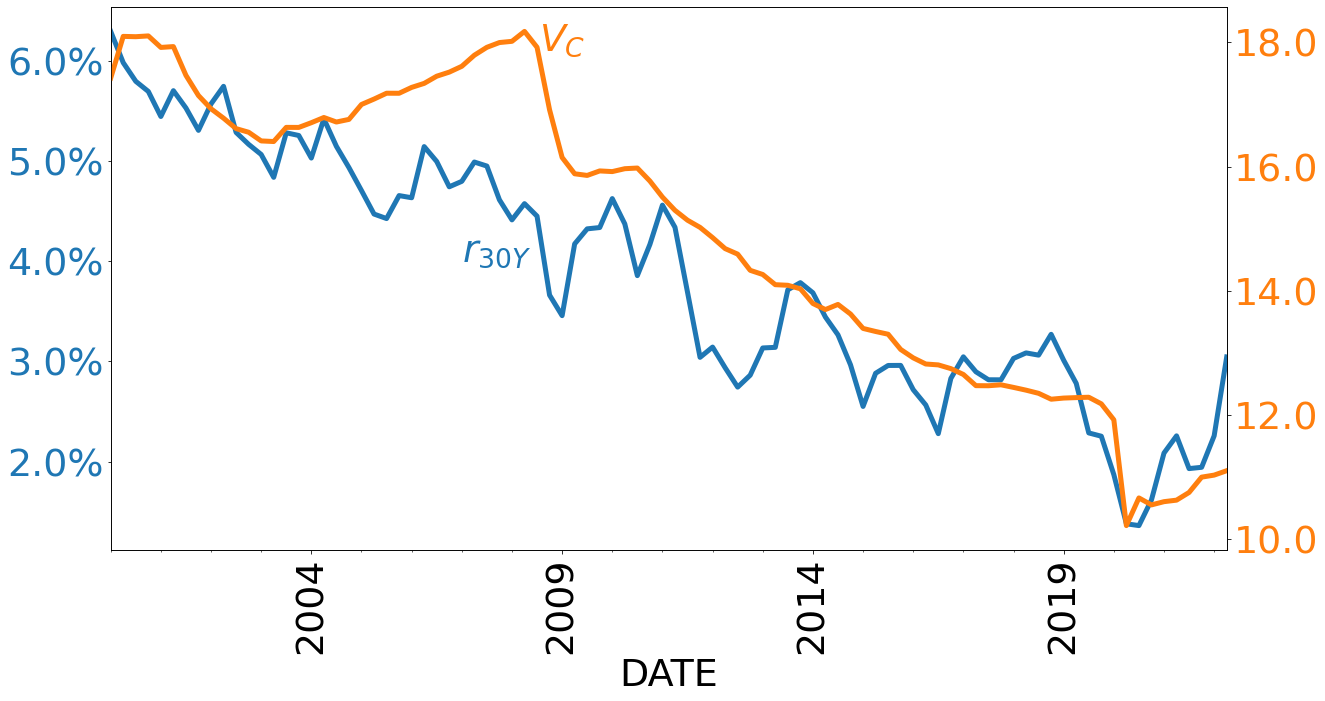

In [6]:
plot_vars = ["Nominal GDP",
            "Currency in Circulation",
            "30 Year UST"]
plot_df = df[plot_vars]
plot_df["$V_C$"] = plot_df["Nominal GDP"].div(plot_df["Currency in Circulation"])
plot_df[plot_vars[2]] = df[plot_vars[2]]
plot_df.dropna(inplace = True)        
plot_vars.append("$V_C$")
plot_vars = plot_vars[2:]
                           
fig, ax = plt.subplots(figsize = (20,10))

plot_df[[plot_vars[0]]].plot.line(ax = ax,
                                    legend = False,
                                 linewidth = 5)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax2 = ax.twinx()
plot_df[[plot_vars[1]]].plot.line(ax = ax2,
                                  legend = False,
                                  color = "C1",
                                 linewidth = 5)
ax.set_yticklabels([str(round(y,1)) + "%" for y in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([round(y,1) for y in ax2.get_yticks()], color = "C1")
ax.text("2007-01-01", 4, "$r_{30Y}$", color = "C0")
ax.text("2009-01-01", 6.1, plot_vars[1],ha = "center", color = "C1")


C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\1200430645.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\1200430645.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), color = "C1")


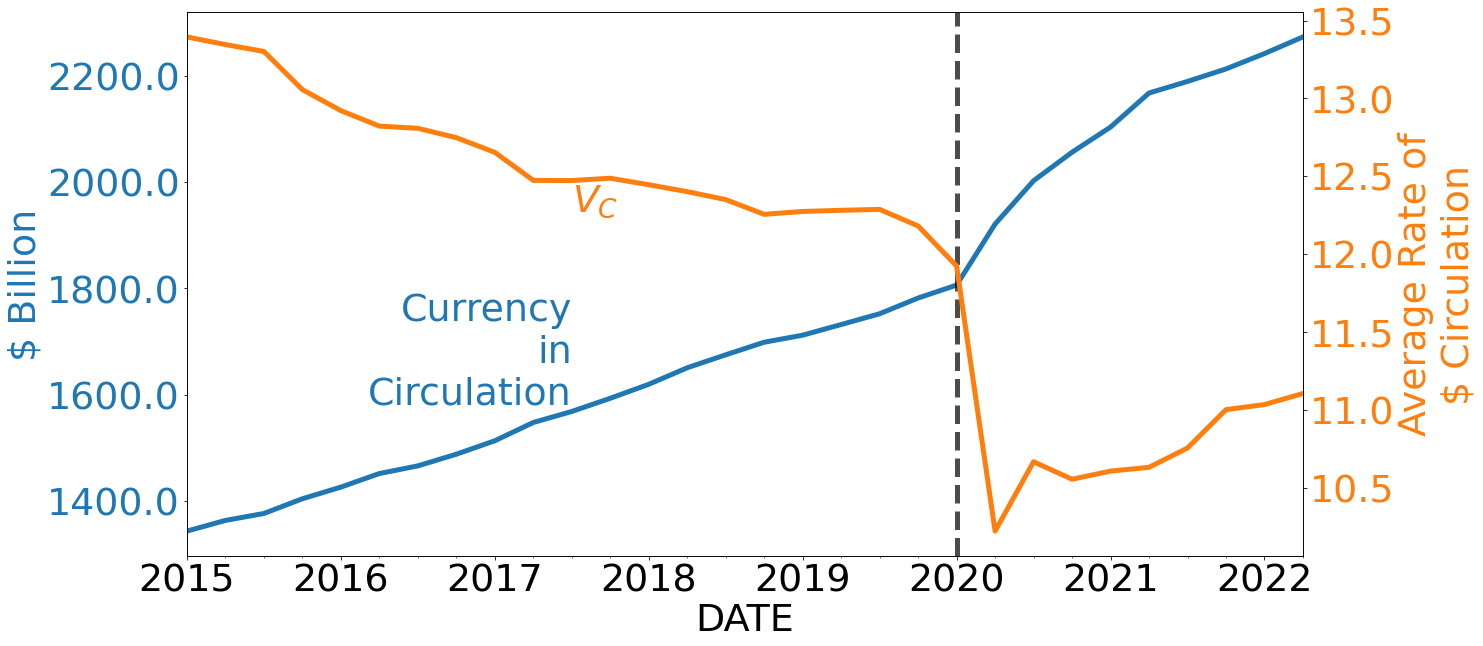

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = ax.twinx()
plot_df=plot_df.loc["2015":]
label_x = plot_df.index[int(len(plot_df.index) / 3)]
var1, var2 = "Currency in Circulation", "$V_C$"
plot_df[[var1]].plot.line(ax = ax, linewidth = 5, legend = False)
plot_df[[var2]].plot.line(ax = ax2, color = "C1", linewidth = 5, legend = False)
ax.set_ylabel("$ Billion", color = "C0")
ax.set_yticklabels(ax.get_yticks(), color = "C0")
ax.text(label_x, plot_df.loc[label_x][var1], var1.replace(" ","\n"), va = "bottom", ha = "right", color = "C0")
ax2.set_ylabel("Average Rate of\n$ Circulation", color = "C1")
ax2.set_yticklabels(ax2.get_yticks(), color = "C1")
ax2.text(label_x, plot_df.loc[label_x][var2], "\n" + var2, va = "center", ha = "left", color = "C1")
ax.axvline("2020-03-01", ls = "--", color = "k", alpha = .7, linewidth = 5)



In [8]:
label_x

Timestamp('2017-09-30 00:00:00', freq='Q-DEC')

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2910154158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["$V_C$"] = df["Nominal GDP"].div(plot_df["Currency in Circulation"])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2910154158.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([round(x*100,2) for x in ax.get_xticks()], rotation = 90)


Text(0.5, 1.0, 'Year-over-year Change in\nYear-over-year Growth Rates\n2008-03-31 to 2022-06-30')

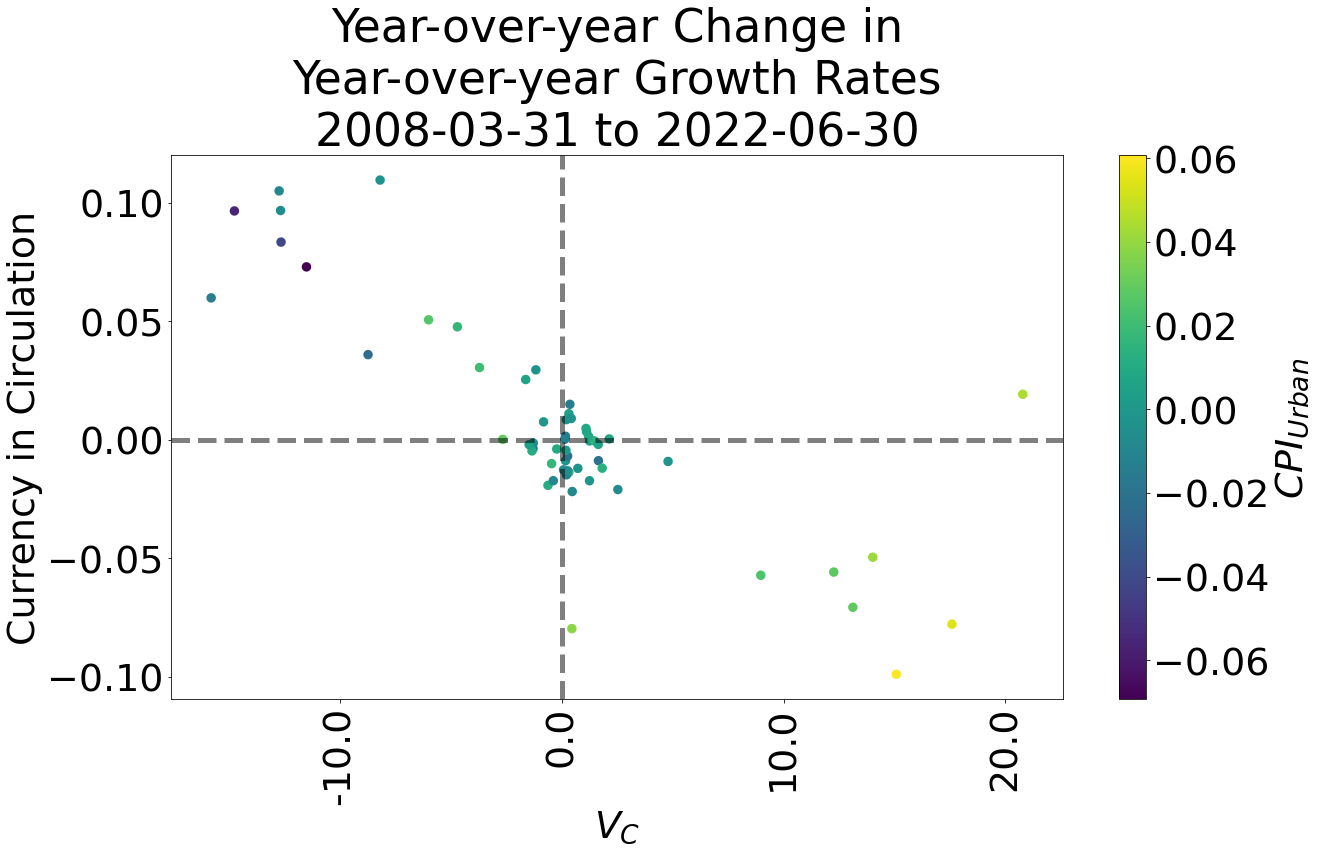

In [9]:
plot_vars = ["Currency in Circulation",
            "$CPI_{Urban}$"]
plot_df = df[plot_vars]  
plot_df["$V_C$"] = df["Nominal GDP"].div(plot_df["Currency in Circulation"])
plot_vars.append("$V_C$")
# plot_df["Nominal GDP"] = plot_df["Nominal GDP"].pct_change(4)
plot_df = plot_df.pct_change(4).diff(4).dropna().loc["2008":]    
plot_df["Date"] = plot_df.index
fig, ax = plt.subplots(figsize = (20,10))

plot_df.plot.scatter(x = plot_vars[2], y = plot_vars[0],c = "$CPI_{Urban}$", cmap = "viridis",
                      ax = ax,
                                    legend = False,
                                 linewidth = 5)

ax.set_xticklabels([round(x*100,2) for x in ax.get_xticks()], rotation = 90)
ax.axhline(0, ls = "--", color = "k", linewidth = 5, alpha = .5)
ax.axvline(0, ls = "--", color = "k", linewidth = 5, alpha = .5)
# ax.text("1994-08-01", 8.2, "$r_{30Y}$", color = "C0")
# ax.text("2009-01-01", 6.1, plot_vars[1],ha = "center", color = "C1")
plot_df.corr()
ax.set_title("Year-over-year Change in\nYear-over-year Growth Rates\n" + str(plot_df.index[0])[:10]+" to " +str(plot_df.index[-1])[:10])

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3193149341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["Nominal GDP"] = plot_df["Nominal GDP"].pct_change(4)
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3193149341.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 90)
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3193149341.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y * 100,1)) + "%" for y in ax.get_yticks()], color = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\3193149341.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.se

[Text(1, -3.0, '-3.0'),
 Text(1, -2.0, '-2.0'),
 Text(1, -1.0, '-1.0'),
 Text(1, 0.0, '0.0'),
 Text(1, 1.0, '1.0'),
 Text(1, 2.0, '2.0')]

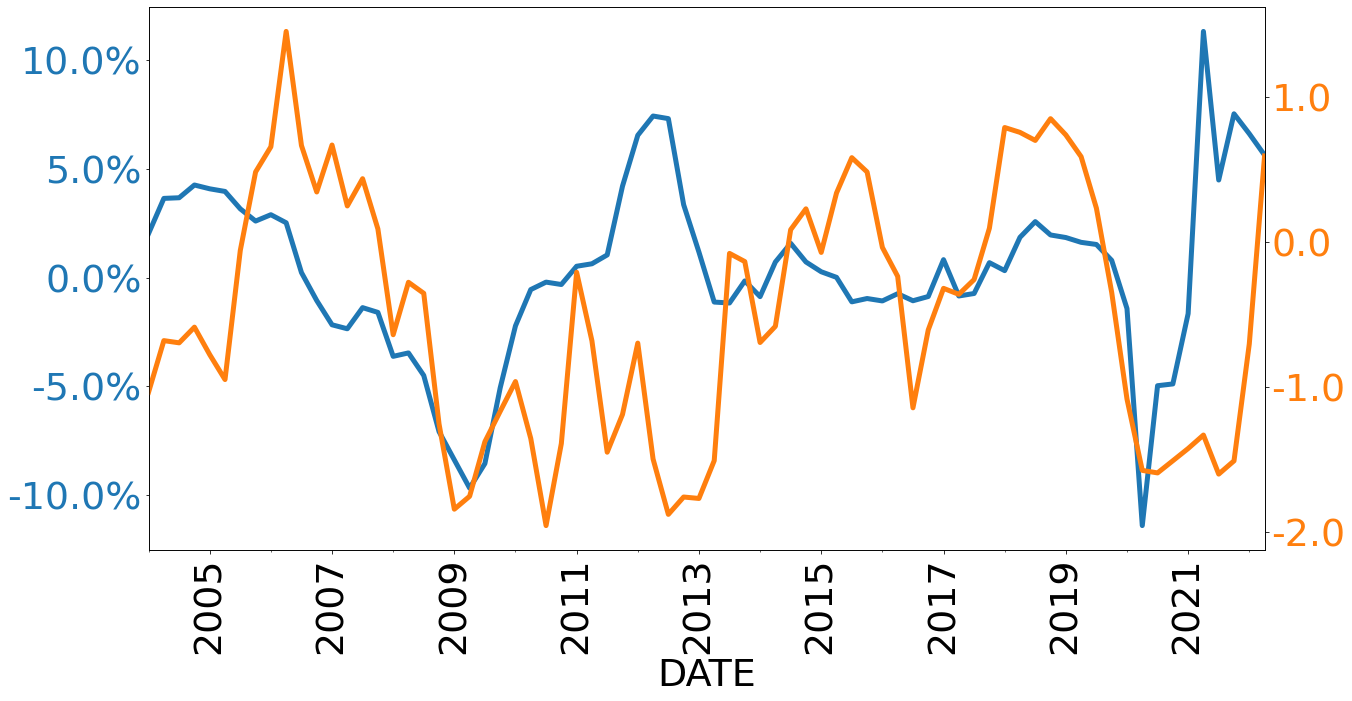

In [10]:
plot_vars = ["Nominal GDP",
            "10 Year UST"]
plot_df = df[plot_vars]  
plot_df["Nominal GDP"] = plot_df["Nominal GDP"].pct_change(4)
plot_df = plot_df.diff(12).dropna()                           
fig, ax = plt.subplots(figsize = (20,10))

plot_df[[plot_vars[0]]].plot.line(ax = ax,
                                    legend = False,
                                 linewidth = 5)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax2 = ax.twinx()
plot_df[[plot_vars[1]]].plot.line(ax = ax2,
                                  legend = False,
                                  color = "C1",
                                 linewidth = 5)
ax.set_yticklabels([str(round(y * 100,1)) + "%" for y in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([round(y,1) for y in ax2.get_yticks()], color = "C1")
# ax.text("1994-08-01", 8.2, "$r_{30Y}$", color = "C0")
# ax.text("2009-01-01", 6.1, plot_vars[1],ha = "center", color = "C1")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\579977854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])


[Text(0, -0.15000000000000002, '-15.0%'),
 Text(0, -0.10000000000000002, '-10.0%'),
 Text(0, -0.05000000000000002, '-5.0%'),
 Text(0, 0.0, '0.0%'),
 Text(0, 0.04999999999999999, '5.0%'),
 Text(0, 0.09999999999999998, '10.0%'),
 Text(0, 0.15000000000000002, '15.0%'),
 Text(0, 0.2, '20.0%')]

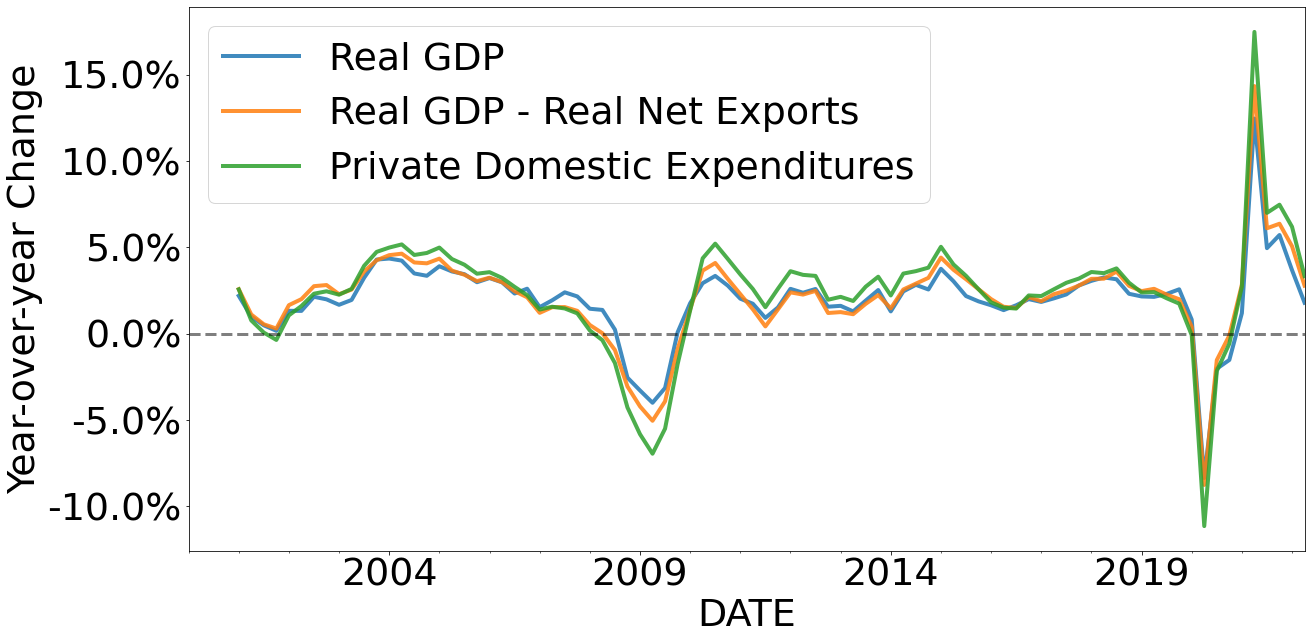

In [11]:
df["Real GDP - Real Net Exports"] = df["Real GDP"].sub(df["Real Net Exports"])
df["Private Domestic Expenditures"] = df["Real Investment"].add(df["Real Consumption"])
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel("Year-over-year Change")
df[["Real GDP", "Real GDP - Real Net Exports", "Private Domestic Expenditures"]].pct_change(4).loc[:].plot.line(linewidth = 4, alpha = .85, ax = ax)
ax.axhline(0, linewidth = 3, linestyle = "--", color = "k", alpha = .5)
ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\2772897060.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])


[Text(0, -0.15000000000000002, '-15.0%'),
 Text(0, -0.10000000000000002, '-10.0%'),
 Text(0, -0.05000000000000002, '-5.0%'),
 Text(0, 0.0, '0.0%'),
 Text(0, 0.04999999999999999, '5.0%'),
 Text(0, 0.09999999999999998, '10.0%'),
 Text(0, 0.15000000000000002, '15.0%')]

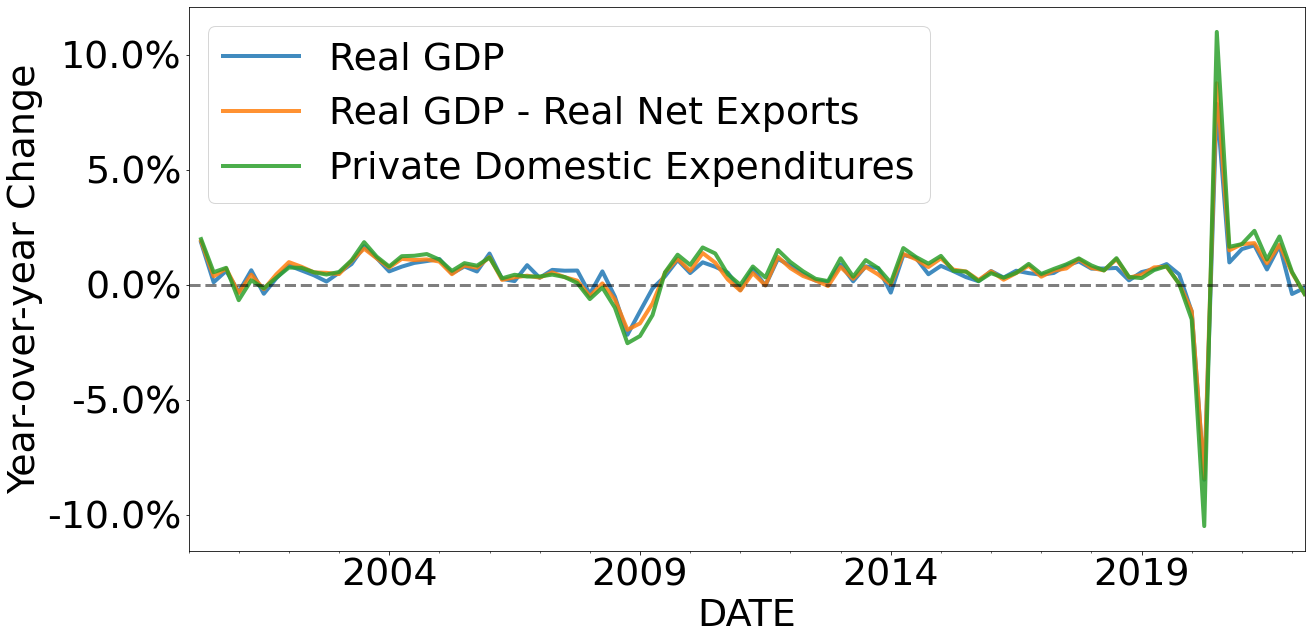

In [12]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel("Year-over-year Change")
df[["Real GDP", "Real GDP - Real Net Exports", "Private Domestic Expenditures"]].pct_change().loc[:].plot.line(linewidth = 4, alpha = .85, ax = ax)
ax.axhline(0, linewidth = 3, linestyle = "--", color = "k", alpha = .5)
ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])

C:\Users\JLCat\AppData\Local\Temp\ipykernel_17128\928125326.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])


[Text(0, -0.1, '-10.0%'),
 Text(0, -0.05, '-5.0%'),
 Text(0, 0.0, '0.0%'),
 Text(0, 0.05000000000000002, '5.0%'),
 Text(0, 0.1, '10.0%')]

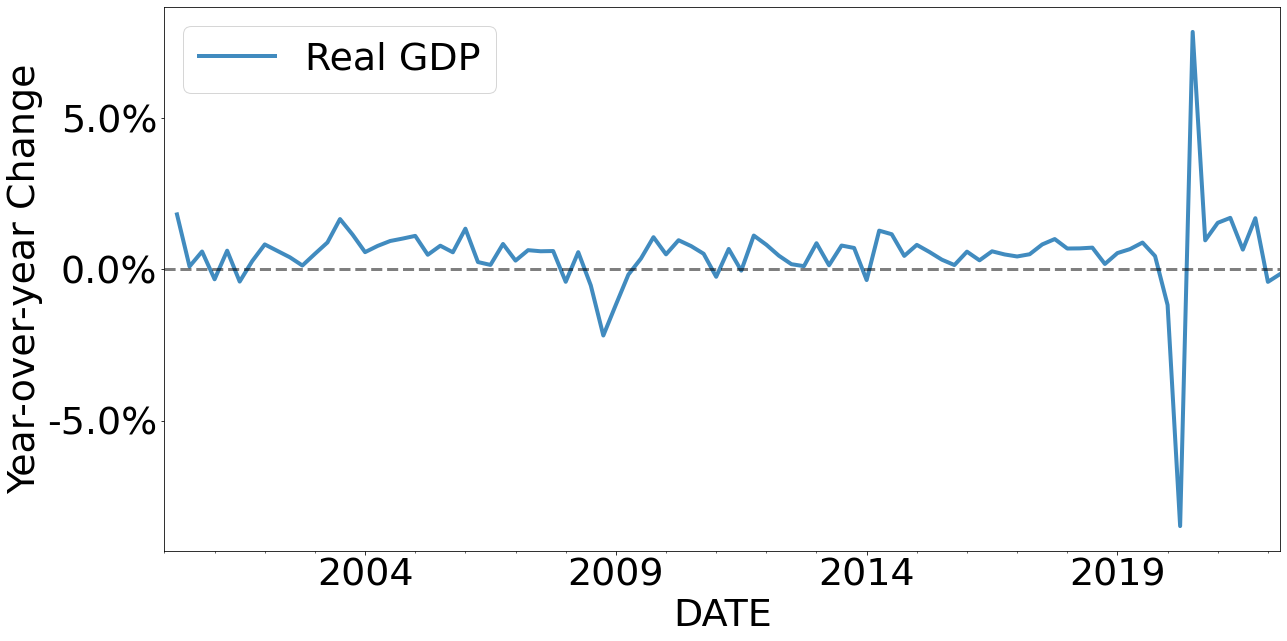

In [13]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_ylabel("Year-over-year Change")
df[["Real GDP"]].pct_change().loc["2000":].plot.line(linewidth = 4, alpha = .85, ax = ax)
ax.axhline(0, linewidth = 3, linestyle = "--", color = "k", alpha = .5)
ax.set_yticklabels([str(round(y * 100,0)) + "%" for y in ax.get_yticks()])

In [14]:
df["Price Deflator"] = df["Nominal GDP"].div(df["Real GDP"])
df.pct_change(4)

,Nominal GDP,Real GDP,Real Net Exports,Real Government EI,Real Investment,Real Consumption,$CPI_{Urban}$,10 Year UST,30 Year UST,Effective Federal Funds Rate (%),Currency in Circulation,Unemployment Rate,Real GDP - Real Net Exports,Private Domestic Expenditures,Price Deflator
DATE,,,,,,,,,,,,,,,
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,0.046795,0.021955,0.120031,0.027584,0.003143,0.031639,0.033935,-0.220181,-0.134888,-0.014212,0.017977,0.049587,0.025814,0.025685,0.024306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,0.173664,0.124609,0.569069,-0.007448,0.212412,0.165568,0.048489,1.313463,0.635269,0.160748,0.128434,-0.544987,0.143401,0.174758,0.043620
2021-09-30,0.102422,0.049557,0.278779,0.007412,0.055952,0.073672,0.053357,1.036263,0.417058,-0.028169,0.093372,-0.422642,0.061069,0.069986,0.050370
2021-12-31,0.121836,0.057171,0.175438,0.005321,0.085968,0.071658,0.066891,0.773694,0.200936,-0.105263,0.076262,-0.374384,0.063690,0.074711,0.061168
